# Corelle — basic usage in Python

by *[Daven Quinn](https://davenquinn.com)*  
Version `1.0.0` — September 2020

In this notebook, we will focus on how to rotate and display both pre-defined and arbitrary geographic features in Python and CartoPy. You can use other plotting tools, [or other languages like Javascript](https://davenquinn.com/viz/corelle-demo-pbdb/), to work with Corelle as well.

In [1]:
%matplotlib inline

## A basic map using CartoPy

First, we should make sure we can plot a basic map using CartoPy. 

In [2]:
import cartopy
import matplotlib.pyplot as P

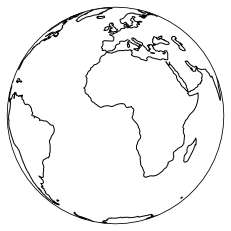

In [3]:
# Make sure we can plot a simple map with CartoPy
ortho = cartopy.crs.Orthographic()
fig = P.figure()
ax = fig.add_subplot(projection=ortho)
ax.coastlines()
fig.show()

## Adding plate polygons from Corelle

Each plate model to be used with Corelle comes with a set of plate polygons. These polygons (in their modern positions) can be found via Corelle's API. Later, we will rotate these back in time quaternion rotation vectors provided separately.

Corelle provides rotations and plate polygons for multiple independent rotation models loaded from GPlates format. The [`/model` API route](https://birdnest.geology.wisc.edu/corelle/api/model) provides a list of available plate models. 

The following HTTP request returns GeoJSON-formatted plate polygons for a given model:

In [4]:
from requests import get
res = get("https://birdnest.geology.wisc.edu/corelle/api/plates?model=Wright2013")
plate_features = res.json()

Convert these plate features to Shapely polygons (**Note:** there are many ways to do this; see for instance [GeoPandas](https://geopandas.org/) for a more *Data Frame*-oriented approach.)

In [5]:
from shapely.geometry import shape
features = [shape(f["geometry"]) for f in plate_features]

...and plot on the globe!

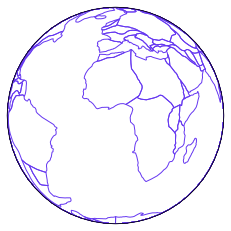

In [6]:
fig = P.figure()
ax = fig.add_subplot(projection=ortho)

ax.add_geometries(features, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')
fig.show()

## Adding pre-split feature layers

Corelle keeps some basic feature layers on the server, pre-split for each plate model. A list of the options can be found at the [/feature API route](https://birdnest.geology.wisc.edu/corelle/api/feature), and more feature types can be added easily.

**Note:** if the features you want to rotate already have an assigned `plate_id`, you don't need to download plate polygons to rotate them — they already have all the information they need.

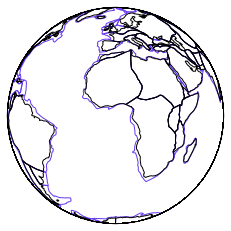

In [7]:
# API call returns GeoJSON format plates

coast_features = get("https://birdnest.geology.wisc.edu/corelle/api/feature/ne_110m_land?model=Wright2013").json()
geometries = [shape(f["geometry"]) for f in coast_features]
ax.add_geometries(geometries, crs=cartopy.crs.Geodetic(), edgecolor="black", facecolor="none")
fig

## The structure of a rotatable feature

Plate features and pre-split features returned from the Corelle server are GeoJSON features encoding polygons on the globe. They have a few additional properties to support rotating:

- `plate_id`: The GPlates ID of the plate this feature is tied to.
- `young_lim`: The last valid time step this plate should exist at (usually 0 Ma).
- `old_lim`: The earliest time step this plate should exist at
- `name`: The human-readable plate ID.

All fields except for `plate_id` are optional.

Here's an example plate polygon:

In [8]:
plate_features[0]

{'id': 202,
 'properties': {'id': 4217,
  'plate_id': 202,
  'young_lim': 0,
  'old_lim': 600.0,
  'name': 'Parana Basin Plate, South America'},
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-54.3065697309999, -39.9785525659999],
     [-54.6479925589999, -40.312862418],
     [-62.2591400839999, -39.8864822829999],
     [-64.0420537629999, -39.4994955179999],
     [-64.2533767059999, -39.1296721709999],
     [-64.3400300739999, -37.3497015449999],
     [-64.0804546319999, -33.574621352],
     [-64.2536545009999, -32.1676300409999],
     [-63.8209610189999, -27.402604832],
     [-57.1066539129999, -29.6706413749999],
     [-55.1404348959999, -30.1981507899999],
     [-49.0062320319999, -31.7093648879999],
     [-51.7864551179999, -36.6206338939999],
     [-53.0331075599999, -38.0013349839999],
     [-53.5290875629999, -38.9932949909999],
     [-54.3065697309999, -39.9785525659999]]]]}}

## Plate rotations

To rotate a feature in Corelle, you need the appropriate plate rotations. These are spherical position vectors that encode a rotation pole and angular distance for each plate and time step. Corelle can represent rotations with an axis-angle or [unit quaternion](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation) representation.

Corelle provides rotations for multiple plate models at arbitrary times between a `max_age` and `min_age` (usually the present). New ones can be loaded on the server from GPlates rotation files.

Here's a rotation for 90 Ma for the [Wright et al., 2013](https://bg.copernicus.org/articles/10/1529/2013/) plate model, in axis-angle representation:

In [24]:
rotations = get("https://birdnest.geology.wisc.edu/corelle/api/rotate?model=Wright2013&time=90").json()
rotations[0]

{'axis': [-0.006488124534775604, 0.021667482218696646, 0.2717914646290833],
 'angle': 0.5524609237863531,
 'plate_id': 202}

And here are some quaternions!

In [25]:
rotations = get("https://birdnest.geology.wisc.edu/corelle/api/rotate?model=Wright2013&time=90&quaternion=true").json()
rotations[:3]

[{'quaternion': [0.9620903409810856,
   -0.006488124534775604,
   0.021667482218696646,
   0.2717914646290833],
  'plate_id': 202},
 {'quaternion': [0.9948537269962158,
   -0.04132061710565584,
   0.05042079677769115,
   0.07756553188143313],
  'plate_id': 604},
 {'quaternion': [0.9913184874654696,
   -0.1127030476626862,
   0.05864625157688082,
   0.03385700271283873],
  'plate_id': 304}]

These formats are interchangeable and both provide a consistent and straightforward mathematical expression. We don't provide Euler angles because they are complex to work with and defined inconsistently.

## Applying rotations

Now, we get to our main purpose: paleogeographic reconstruction!
We can rotate any feature for which the `plate_id` is known. Since pre-split features already ship with
`plate_id` set, this is easy! The functions in the `corelle_helper` libraries do this by applying the quaternion rotations
sent back from Corelle to the features for each plate. Then we can plot using normal Python plotting functionality.

Here, we apply our 90 Ma rotations to the plate features and coastlines, and then plot them. The `rotate_features` function used here spits out [Shapely](https://shapely.readthedocs.io/en/latest/)-compatible features, which can be plotted by CartoPy and other libraries, or serialized to JSON.

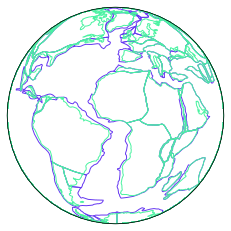

In [35]:
from corelle_helpers import rotate_features, rotate_geometry
import numpy as N

fig = P.figure()
ax = fig.add_subplot(projection=ortho)

# Rotate our plate polygons
feat = list(rotate_features(rotations, plate_features))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')

# Rotate our coastline features
feat = list(rotate_features(rotations, coast_features))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#4af2a1", facecolor="none")
fig.show()

Pre-split [Macrostrat](https://macrostrat.org) column footprints are also provided by Corelle:

In [36]:
macrostrat_columns = get("https://birdnest.geology.wisc.edu/corelle/api/feature/macrostrat_columns?model=Wright2013").json()
# Rotate our coastline features
feat = list(rotate_features(rotations, macrostrat_columns))
ax.add_geometries(feat, crs=cartopy.crs.Geodetic(), edgecolor="#ff00aa", facecolor="none")
fig

## Rotating user-provided features

One of the primary benefits of the Corelle plate-rotation system is the ability to rotate externally-provided features, without needing to receive or manage them in a centralized location. This enables easy rotation of features from any source.

Here, we will rotate fossil collections from the [Paleobiology Database](https://paleobiodb.org), focusing on the time near the [Permian-Triassic mass extinction](https://en.wikipedia.org/wiki/Permian%E2%80%93Triassic_extinction_event). The same rotation process drives each time step of [this Javascript demo](https://davenquinn.com/viz/corelle-demo-pbdb/).

We can use the PaleobioDB's data service to return a set of locale summaries for fossil collections of approximately this age: each one has a unique identifier, (present-day) geographic information, and the number of collections and occurrances.

In [13]:
# Get collections in 4 Myr window
collections = get("https://paleobiodb.org/data1.2/colls/summary.json", params={
    "level": 3,
    "max_ma": 254,
    "min_ma": 249,
    "show": "time"
}).json()["records"]
collections[:3]

[{'oid': 'clu:306990087',
  'nco': 5,
  'noc': 33,
  'lng': 169.739806,
  'lat': -46.371055,
  'cxi': '652'},
 {'oid': 'clu:306280249',
  'nco': 4,
  'noc': 4,
  'lng': 134.152781,
  'lat': 34.711415,
  'cxi': '652'},
 {'oid': 'clu:306140321',
  'nco': 1,
  'noc': 1,
  'lng': 127.285997,
  'lat': 70.770666,
  'cxi': '652'}]

### Which plate rotates each feature?

The only added complexity for rotating features that don't come from Corelle is determining which plate to use to rotate each feature. For large polygon features that span multiple plates, it may be desirable to also split the features based on plate ID.

For either of these operations, we need to perform a "spatial join" between our features and Corelle's plate polygons. This is a fundamental GIS operation, so there are plenty of tools to achieve it in Python.

The [**Pandas**](pandas.pydata.org/) module gives us good tools to organize structured data, and its [**GeoPandas** extension](https://geopandas.org/) has built-in functionality for spatial joins. If more granualar control over the spatial joining process is needed, a lower-level computational geometry package such as [**Shapely**](https://shapely.readthedocs.io/en/latest/manual.html) should be used.

First, we create a basic data frame:

In [14]:
from pandas import DataFrame

df = DataFrame(collections)
df[:5]

cxi        lat         lng  nco  noc            oid
0  652 -46.371055  169.739806    5   33  clu:306990087
1  652  34.711415  134.152781    4    4  clu:306280249
2  652  70.770666  127.285997    1    1  clu:306140321
3  652  -8.760970  126.350167    1    1  clu:306120162
4  652  31.726950  120.676394    1    1  clu:306010243

Next, we can [convert this to a **Geo**DataFrame](https://geopandas.org/gallery/create_geopandas_from_pandas.html):

In [15]:
from geopandas import GeoDataFrame, points_from_xy

geo_coll = GeoDataFrame(df, geometry=points_from_xy(df.lng, df.lat)).drop(columns=["lng", "lat"])
geo_coll[:5]

cxi  nco  noc            oid                              geometry
0  652    5   33  clu:306990087         POINT (169.739806 -46.371055)
1  652    4    4  clu:306280249          POINT (134.152781 34.711415)
2  652    1    1  clu:306140321  POINT (127.285997 70.77066600000001)
3  652    1    1  clu:306120162           POINT (126.350167 -8.76097)
4  652    1    1  clu:306010243           POINT (120.676394 31.72695)

We can convert our GeoJSON plate polygons to a `GeoDataFrame` as well:

In [16]:
plates = GeoDataFrame.from_features(plate_features)
plates[:5]

geometry    id  \
0  (POLYGON ((-54.3065697309999 -39.9785525659999...  4217   
1  (POLYGON ((131.256438242 42.294640164, 130.210...  4178   
2  (POLYGON ((-5.36976009399996 44.822788518, -3....  4179   
3  (POLYGON ((-51.7854473929999 83.2100825630001,...  4180   
4  (POLYGON ((35.7585905220001 33.8153430630001, ...  4181   

                                name  old_lim  plate_id  young_lim  
0  Parana Basin Plate, South America    600.0       202        0.0  
1                        North China    600.0       604        0.0  
2                             Iberia    600.0       304        0.0  
3            Canadian Arctic Islands    600.0       106        0.0  
4                      Sinai, Africa    600.0       508        0.0

The core of our "spatial join" is the [`overlay` function](https://geopandas.org/set_operations.html) from GeoPandas. This essentially "merges" the data frames, adding the non-geometry columns of overlapping plate polygons. The critical new piece of this is the `plate_id` column.

In [17]:
from geopandas import overlay

# Note: `rtree` module must be installed
# This function classifies all points by their overlapping (modern) plates
plate_collections = overlay(geo_coll.copy(), plates, how='identity')
plate_collections[:5]

cxi  nco   noc            oid      id               name  old_lim  \
0  652  5.0  33.0  clu:306990087  4293.0  South New Zealand    300.0   
1  715  1.0   2.0  clu:306990088  4293.0  South New Zealand    300.0   
2  715  2.0  21.0  clu:306980087  4293.0  South New Zealand    300.0   
3  715  1.0   9.0  clu:306970089  4293.0  South New Zealand    300.0   
4  715  3.0  39.0  clu:306960088  4293.0  South New Zealand    300.0   

   plate_id  young_lim                       geometry  
0     807.0        0.0  POINT (169.739806 -46.371055)  
1     807.0        0.0  POINT (169.942627 -45.890005)  
2     807.0        0.0  POINT (169.192114 -46.158011)  
3     807.0        0.0   POINT (168.60875 -45.262223)  
4     807.0        0.0  POINT (168.223563 -45.858174)

Then we get the appropriate rotations from Corelle and apply them using the slick `rotate_dataframe` function from our [corelle_helpers](corelle_helpers.py) module. These are now paleo-positions! If we supply an optional `time` argument, it gets added to the data frame.

In [18]:
from corelle_helpers import rotate_dataframe

rotations = get("https://birdnest.geology.wisc.edu/corelle/api/rotate", params={
    "model": "Wright2013",
    "time": 252, # 252 Ma
    "quaternion": True
}).json()

rotated_collections = rotate_dataframe(plate_collections, rotations, time=252)
rotated_collections[:5]

cxi  nco   noc            oid      id               name  old_lim  \
0  652  5.0  33.0  clu:306990087  4293.0  South New Zealand    300.0   
1  652  5.0  33.0  clu:306990087  4293.0  South New Zealand    300.0   
2  715  1.0   2.0  clu:306990088  4293.0  South New Zealand    300.0   
3  715  1.0   2.0  clu:306990088  4293.0  South New Zealand    300.0   
4  715  2.0  21.0  clu:306980087  4293.0  South New Zealand    300.0   

   plate_id  young_lim                                       geometry  time  
0     807.0        0.0  POINT (-78.95998881223855 -88.14523257491319)   252  
1     807.0        0.0  POINT (-78.95998881223855 -88.14523257491319)   252  
2     807.0        0.0  POINT (-85.01762163518454 -87.69420510160182)   252  
3     807.0        0.0  POINT (-85.01762163518454 -87.69420510160182)   252  
4     807.0        0.0   POINT (-92.49352990823031 -88.2172125730979)   252

Finally, we can plot the results!

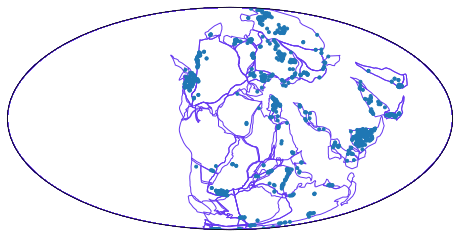

In [19]:
fig = P.figure(figsize=(8,5))
ax = fig.add_subplot(projection=cartopy.crs.Mollweide())

# Rotate our plate polygons
p_rot = rotate_dataframe(plates, rotations)
ax.add_geometries(p_rot.geometry, crs=cartopy.crs.Geodetic(), edgecolor="#6638f0", facecolor='none')

# Plot our rotated collections
ax.plot(rotated_collections.geometry.x, rotated_collections.geometry.y, '.', transform=cartopy.crs.Geodetic())
#ax.add_geometries(rotated_collections.geometry, crs=cartopy.crs.Geodetic(), edgecolor="#4af2a1", facecolor="none")

# Matplotlib tries to limit our axes
ax.set_global()

fig.show()

# Repeating with another plate model

We can easily go through the same rotation process for a different plate model, using the same features with new plates and rotations:

In [20]:
rotations2 = get("https://birdnest.geology.wisc.edu/corelle/api/rotate", params={
    "model": "Scotese",
    "time": 252, # 252 Ma
    "quaternion": True
}).json()
_plates = get("https://birdnest.geology.wisc.edu/corelle/api/plates", params={
    "model": "Scotese",
}).json()

plates_scotese = GeoDataFrame.from_features(_plates)


plate_collections = overlay(geo_coll, plates_scotese, how='identity')
scotese_collections = rotate_dataframe(plate_collections, rotations2, time=252)
scotese_collections[:5]

cxi  nco   noc            oid    id  name  old_lim  plate_id  young_lim  \
0  652  5.0  33.0  clu:306990087  4757  None    270.0       807          0   
1  715  1.0   2.0  clu:306990088  4757  None    270.0       807          0   
2  715  2.0  21.0  clu:306980087  4757  None    270.0       807          0   
3  715  1.0   9.0  clu:306970089  4757  None    270.0       807          0   
4  715  3.0  39.0  clu:306960088  4757  None    270.0       807          0   

                                       geometry  time  
0   POINT (175.7639517490847 -76.2127832242806)   252  
1  POINT (177.7235596853633 -76.03846665615791)   252  
2   POINT (175.560831638893 -75.78111620609721)   252  
3  POINT (177.4160867479929 -74.91603944973164)   252  
4   POINT (174.952933181196 -75.06067493622402)   252

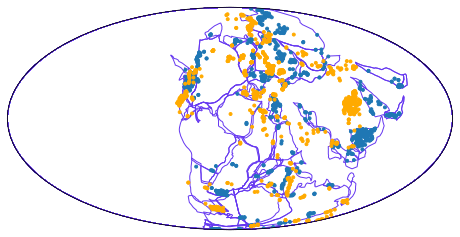

In [21]:
ax.plot(scotese_collections.geometry.x, scotese_collections.geometry.y, '.', transform=cartopy.crs.Geodetic(), color="#ffaa00")
ax.set_global()
fig

As we reach back in time, the differences between plate models can grow — this is why it is important to build flexible systems that can easily integrate multiple models. The differences between models can be especially important for paleoclimate reconstructions.

## Conclusion

These plotting capabilities build towards the integrative analytical techniques discussed in [the next tutorial](Corelle-Paleolatitude.ipynb).